In [1]:
import os 
import xarray as xr
import numpy as np 
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import scipy.fftpack as fp
import pandas as pd

In [2]:
ask_workers = 24

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=ask_workers,dashboard_address=':8686')
c = Client(cluster)
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8686/status,
Dashboard: http://127.0.0.1:8686/status,Workers: 24
Total threads: 24,Total memory: 187.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43607,Workers: 24
Dashboard: http://127.0.0.1:8686/status,Total threads: 24
Started: Just now,Total memory: 187.53 GiB
Comm: tcp://127.0.0.1:44209,Total threads: 1
Dashboard: http://127.0.0.1:38763/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:36451,


## Load data

In [5]:
dir_data = '/bettik/leguilfl/Studies/MASSH_CCS/data/32_39_233_236'

In [6]:
ds = xr.open_mfdataset(os.path.join(dir_data,'ssh_filt*.nc'))
print(ds)

<xarray.Dataset>
Dimensions:   (time: 7320, lat: 73, lon: 29)
Coordinates:
  * time      (time) datetime64[ns] 2012-01-02T17:00:00 ... 2012-11-02T16:00:00
  * lat       (lat) float64 32.0 32.1 32.2 32.3 32.4 ... 38.9 39.0 39.1 39.2
  * lon       (lon) float64 233.2 233.3 233.4 233.5 ... 235.7 235.8 235.9 236.0
Data variables:
    ssh_full  (time, lat, lon) float64 dask.array<chunksize=(24, 73, 29), meta=np.ndarray>
    ssh_corr  (time, lat, lon) float64 dask.array<chunksize=(24, 73, 29), meta=np.ndarray>
    ssh_bm    (time, lat, lon) float64 dask.array<chunksize=(24, 73, 29), meta=np.ndarray>
    ssh_bar   (time, lat, lon) float64 dask.array<chunksize=(24, 73, 29), meta=np.ndarray>
    ssh_igw   (time, lat, lon) float64 dask.array<chunksize=(24, 73, 29), meta=np.ndarray>


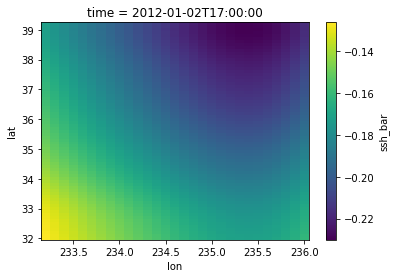

In [14]:
ds.ssh_bar[0].plot()

In [7]:
lon = ds.lon.values
lat = ds.lat.values
time= ds.time.values
ny = lat.size
nx = lon.size
nt = time.size


## Extract semi diurnal internal tides

In [8]:
def gaspari_cohn(r,c):

    if type(r) is float or type(r) is int:
        ra = np.array([r])
    else:
        ra = r
    if c<=0:
        return np.zeros_like(ra)
    else:
        ra = 2*np.abs(ra)/c
        gp = np.zeros_like(ra)
        i= np.where(ra<=1.)[0]
        gp[i]=-0.25*ra[i]**5+0.5*ra[i]**4+0.625*ra[i]**3-5./3.*ra[i]**2+1.
        i =np.where((ra>1.)*(ra<=2.))[0]
        gp[i] = 1./12.*ra[i]**5-0.5*ra[i]**4+0.625*ra[i]**3+5./3.*ra[i]**2-5.*ra[i]+4.-2./3./ra[i]
        if type(r) is float:
            gp = gp[0]
    return gp


In [9]:
wint = np.ones(3*nt)
wint[:nt] = gaspari_cohn(np.arange(0,nt,1),nt)[::-1]
wint[2*nt:] = gaspari_cohn(np.arange(0,nt),nt)

dt = 3600 # seconds

w = fp.fftfreq(3*nt,dt)# seconds^-1
nw = w.size

w1 = 1/15/3600
w2 = 1/9/3600
H = (np.abs(w)>w1) & (np.abs(w)<w2)
w_filtered = H*w


In [10]:
ssh_it_12h = xr.DataArray(np.empty(ds.ssh_igw.shape), dims=['time','lat','lon'])

for iy in range(ny):
    print(iy,end='\r')
    ssh_y = ds.ssh_igw.isel(lat=iy).values
    mask = np.isnan(ssh_y)
    ssh_y[mask] = 0
    for ix in range(nx):
        ssh_extended = np.zeros((3*nt,))
        ssh_extended[nt:2*nt] = ssh_y[:,ix]
        ssh_extended[:nt] = ssh_y[::-1,ix]
        ssh_extended[2*nt:] = ssh_y[::-1,ix]
        ssh_win = wint * ssh_extended 
        ssh_f_t = fp.fft(ssh_win)
        ssh_f_filtered =  H * ssh_f_t
        ssh_it_12h[:,iy,ix] = np.real(fp.ifft(ssh_f_filtered))[nt:2*nt]
    ssh_it_12h[:,iy].data[mask] = np.nan

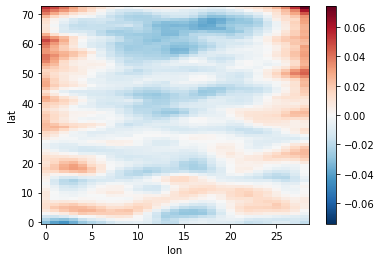

In [11]:
ssh_it_12h[nt//2].plot()

## Extract internal tides spatial modes

In [10]:
def lonlat2dxdy(lon,lat):
    dlon = np.gradient(lon)
    dlat = np.gradient(lat)
    dx = np.sqrt((dlon[1]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[1]*111000)**2)
    dy = np.sqrt((dlon[0]*111000*np.cos(np.deg2rad(lat)))**2
                 + (dlat[0]*111000)**2)
    dx[0,:] = dx[1,:]
    dx[-1,: ]= dx[-2,:] 
    dx[:,0] = dx[:,1]
    dx[:,-1] = dx[:,-2]
    dy[0,:] = dy[1,:]
    dy[-1,:] = dy[-2,:] 
    dy[:,0] = dy[:,1]
    dy[:,-1] = dy[:,-2]
    return dx,dy


lon2d,lat2d = np.meshgrid(lon,lat)
dx,dy = lonlat2dxdy(lon2d,lat2d)
dx0 = dx.mean()
dy0 = dy.mean()

kx = np.fft.fftfreq(3*nx,dx0*1e-3) # km
ky = np.fft.fftfreq(3*ny,dy0*1e-3) # km
k, l = np.meshgrid(kx,ky)
wavnum2D = np.sqrt(k**2 + l**2)

k1 = 0.0070
k2 = 0.0126
k3 = 0.0191
k4 = 0.0269



## Spatial window
winy = np.ones(3*ny)
winy[:ny] = gaspari_cohn(np.arange(0,ny,1),ny)[::-1]
winy[2*ny:] = gaspari_cohn(np.arange(0,ny),ny)

winx = np.ones(3*nx)
winx[:nx] = gaspari_cohn(np.arange(0,nx,1),nx)[::-1]
winx[2*nx:] = gaspari_cohn(np.arange(0,nx),nx)

window = winy[:,np.newaxis] * winx[np.newaxis,:]

kernel = Gaussian2DKernel(x_stddev=6)

In [11]:
def extend(ssh):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended


def apply_filter(ssh_freq,H):
    ssh_freq_filtered = H * ssh_freq
    ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))
    return ssh_filtered

def bandpass(wavenumbers):
    _bandpass = np.zeros((3*ny,3*nx))
    for i in range(3*ny):
        for j in range(3*nx):
            if wavnum2D[i,j]>wavenumbers[0] and wavnum2D[i,j]<wavenumbers[1]:
                _bandpass[i,j] = 1
    return _bandpass



wavenumbers_mode_1 = [0.5*k1,0.5*(k1+k2)] # in km
wavenumbers_mode_2 = [0.5*(k1+k2),0.5*(k2+k3)] # in km
wavenumbers_mode_3 = [0.5*(k2+k3),0.5*(k3+k4)] # in km

bandpass_mode_1 = bandpass(wavenumbers_mode_1)
bandpass_mode_2 = bandpass(wavenumbers_mode_2)
bandpass_mode_3 = bandpass(wavenumbers_mode_3)



In [12]:
frame_per_files = 1
import gc
def create_dataset(t0,path):
    _nt = min(frame_per_files,nt-t0)
    shapeout = (_nt,lat.size,lon.size)
    _ssh = ssh_it_12h.isel(time=slice(t0,t0+_nt))
    _ssh_1 = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    _ssh_2 = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    _ssh_3 = xr.DataArray(np.empty(shapeout), dims=['time','lat','lon'])
    
    for i in range(_nt):
        ssh0 = ssh_it_12h[t0+i].values
        mask = np.isnan(ssh0)
        
        # Extend
        ssh_extended = extend(ssh0)
        ssh_extended[np.abs(ssh_extended)>0.1] = np.nan
        
        # Remove nans
        ssh_extended_noNans = interpolate_replace_nans(ssh_extended, kernel)
        
        # Windowing
        ssh_win = ssh_extended_noNans * window
        
        # FFT
        ssh_freq = fp.fft2(ssh_win)
        
        # Filter
        _ssh_1_np = apply_filter(ssh_freq, bandpass_mode_1)[ny:2*ny,nx:2*nx]
        _ssh_2_np = apply_filter(ssh_freq, bandpass_mode_2)[ny:2*ny,nx:2*nx]
        _ssh_3_np = apply_filter(ssh_freq, bandpass_mode_3)[ny:2*ny,nx:2*nx]
        
        # Mask
        _ssh_1_np[mask] = np.nan
        _ssh_2_np[mask] = np.nan
        _ssh_3_np[mask] = np.nan
        
        # Fill array
        _ssh_1[i] = _ssh_1_np
        _ssh_2[i] = _ssh_2_np
        _ssh_3[i] = _ssh_3_np
        
    dsout = xr.Dataset({'ssh_it':(('time','lat','lon'),_ssh.data),
                        'ssh_it_1':(('time','lat','lon'),_ssh_1.data),
                        'ssh_it_2':(('time','lat','lon'),_ssh_2.data),
                        'ssh_it_3':(('time','lat','lon'),_ssh_3.data),
                       },
                       coords={'time':('time',time[t0:t0+_nt]),'lat':('lat',lat),'lon':('lon',lon)}
                      )
    dsout.to_netcdf(path)
    
    dsout.close()
    del dsout
    
    del _ssh,_ssh_1,_ssh_2,_ssh_3,ssh0,_ssh_1_np,_ssh_2_np,_ssh_3_np,mask,ssh_freq,ssh_win,ssh_extended_noNans,ssh_extended
    gc.collect()
    
    return path

In [13]:
time_save = np.arange(0,nt,frame_per_files)

def create_filepath(date, prefix='ssh_it', root_path=dir_data):
    filepath = f'{root_path}/{prefix}_{date}.nc'
    return filepath

dates = [pd.to_datetime(str(ds.time.data[t])).strftime("%Y-%m-%d_%H") for t in time_save]
paths = [create_filepath(date) for date in dates]


In [14]:
create_dataset(time_save[0],paths[0])

'/bettik/leguilfl/Studies/MASSH_CCS/data/20_40_220_240/ssh_it_2012-01-04_11.nc'

In [ ]:
from dask import delayed,compute
delayed_results = []
for t0,path in zip(time_save,paths):
    res = delayed(create_dataset)(t0, path)
    delayed_results.append(res)
results = compute(*delayed_results, scheduler="processes")

/home/leguilfl/anaconda3/envs/jupyter/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 1 leaked semaphores to clean up at shutdown
  len(cache))
/home/leguilfl/anaconda3/envs/jupyter/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 1 leaked semaphores to clean up at shutdown
  len(cache))
/home/leguilfl/anaconda3/envs/jupyter/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 1 leaked semaphores to clean up at shutdown
  len(cache))
/home/leguilfl/anaconda3/envs/jupyter/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 1 leaked semaphores to clean up at shutdown
  len(cache))
/home/leguilfl/anaconda3/envs/jupyter/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 1 leaked semaphores to clean up at shutdown